In [7]:
from unet_val import UNet
import sys
import numpy as np
import os
import cv2
import logging
from image_utils import standardize,write_data_h5
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.backends.cudnn as cudnn
from dataset_generator_2 import Dataset_sat
from torch.utils.data import DataLoader
from IOU_computations import *
from resunet_main_fin import predict,criterion
from numpy import newaxis


In [8]:
%matplotlib inline

In [9]:
!gpustat

mnemosyne  Mon Apr 30 22:03:08 2018
[0] TITAN Xp         | 65'C,  18 % |  4571 / 12187 MB | s132314(4561M)
[1] TITAN Xp         | 70'C,  35 % | 10057 / 12189 MB | alcor(10047M)
[2] TITAN Xp         | 41'C,   0 % |   585 / 12189 MB | s161362(575M)
[3] TITAN Xp         | 35'C,   2 % |     0 / 12189 MB |


In [15]:
SET='TEST/'
path_data='../2_DATA_GHANA/DATASET/120_x_120_8_pansh/'+SET
path_clean_data='../2_CLEAN_DATA_GHANA/DATASET/120_x_120_8_pansh/'+SET
if not os.path.exists(path_clean_data):
            os.makedirs(path_clean_data)
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')
path_wrong_data='../2_WRONG_DATA_GHANA/DATASET/120_x_120_8_pansh/'+SET
if not os.path.exists(path_wrong_data):
            os.makedirs(path_wrong_data)
path_model='MODEL_VAL_GHANA/RESUNET_val_ghana_restored2.ckptCP62000.pth'


In [16]:
INPUT_CHANNELS=9
NB_CLASSES=2
DEFAULT_LAYERS=3
DEFAULT_FEATURES_ROOT=32
DEFAULT_WIDTH_KERNEL=3
BATCH_SIZE=100

TMP_IOU='NEW_DATASET_TMP_IOU/'
if not os.path.exists(TMP_IOU):
        os.makedirs(TMP_IOU)
loss_fn=nn.CrossEntropyLoss()

Image 0, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00028882
Image 1, Validation IoU 0.3105, Validation IoU_acc 42.8571%,Validation F1 IoU 50.0000%, loss 0.33775997
Image 1, Validation IoU 0.3105, Validation IoU_acc 42.8571%,Validation F1 IoU 50.0000%, loss 0.33775997


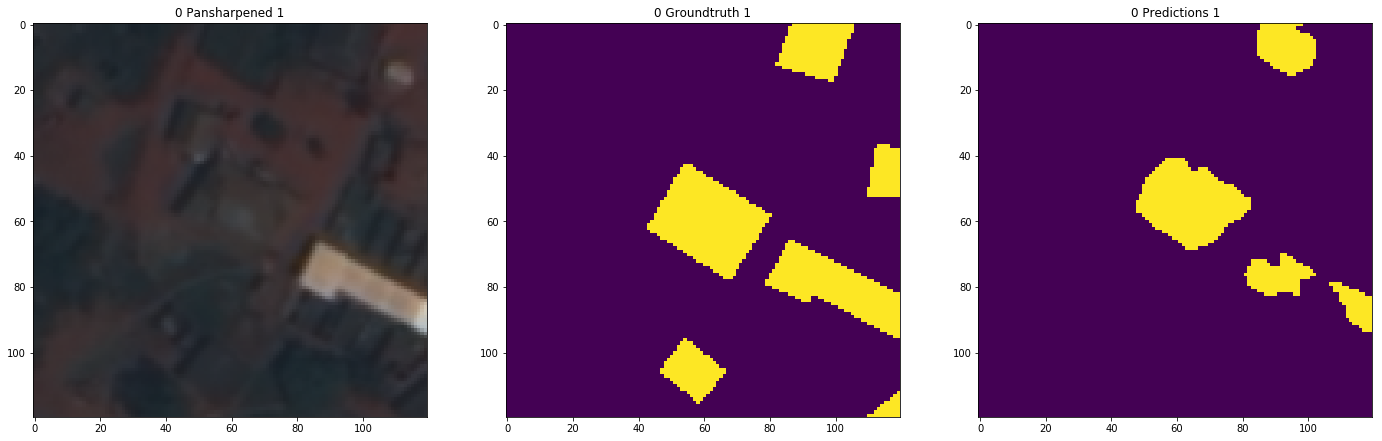

Is the grountruth true:Y or N?y
../2_CLEAN_DATA_GHANA/DATASET/120_x_120_8_pansh/TEST/INPUT/input_1.h5
Image 2, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00032879
Image 3, Validation IoU 0.8336, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.09638198
Image 4, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00098249
Image 5, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00003916
Image 6, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00004478
Image 7, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00004264
Image 8, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00026739
Image 9, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00162394
Image 10, Validation IoU 0.8234, Validation IoU_ac

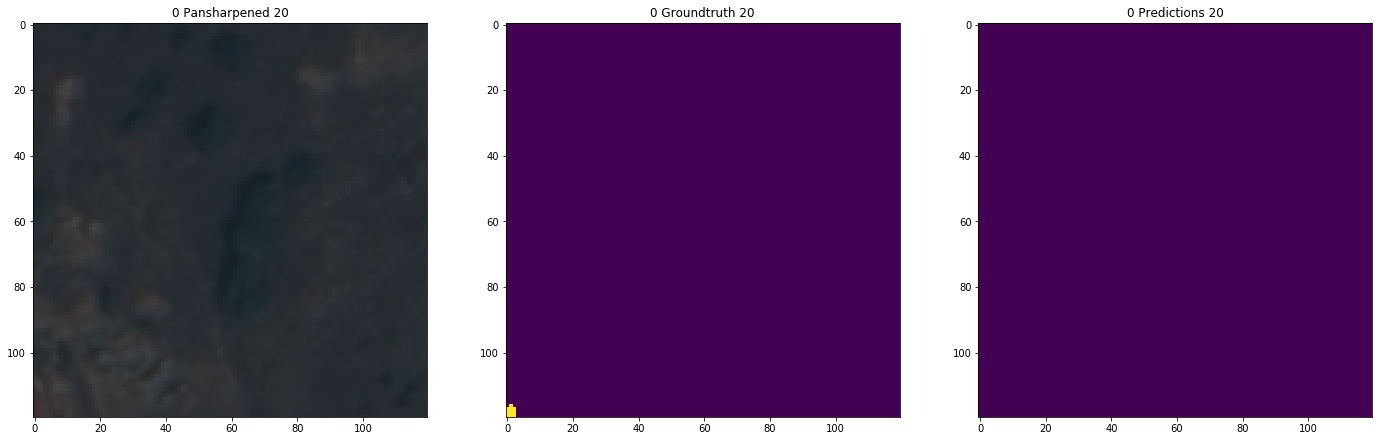

Is the grountruth true:Y or N?n
../2_WRONG_DATA_GHANA/DATASET/120_x_120_8_pansh/TEST/INPUT/input_0.h5
Image 21, Validation IoU 0.0516, Validation IoU_acc 6.6667%,Validation F1 IoU 9.5238%, loss 1.66288626
Image 21, Validation IoU 0.0516, Validation IoU_acc 6.6667%,Validation F1 IoU 9.5238%, loss 1.66288626


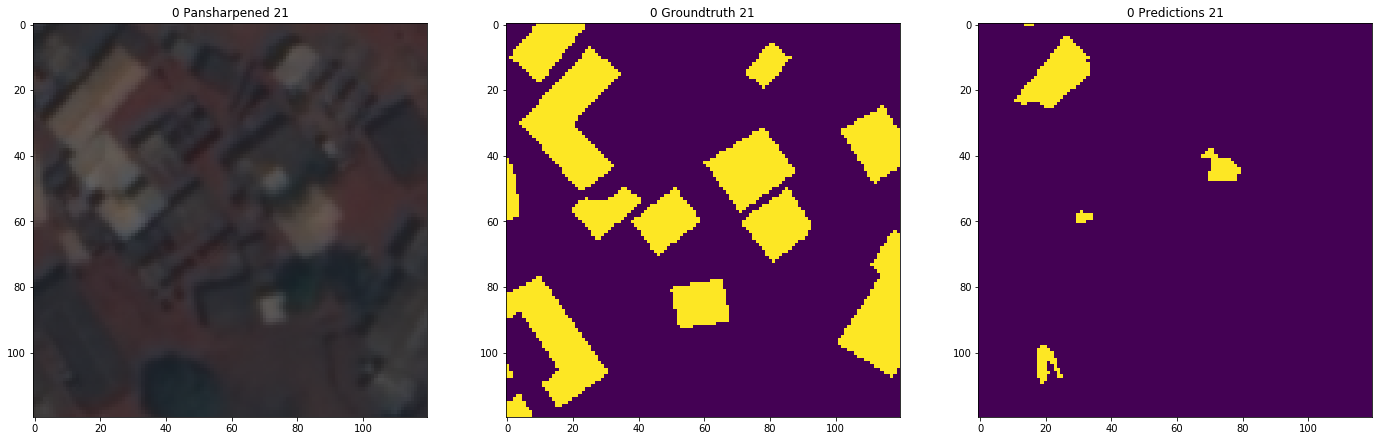

Is the grountruth true:Y or N?y
../2_CLEAN_DATA_GHANA/DATASET/120_x_120_8_pansh/TEST/INPUT/input_20.h5
Image 22, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00075809
Image 23, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00005731
Image 24, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00004486
Image 25, Validation IoU 0.9994, Validation IoU_acc 100.0000%,Validation F1 IoU 50.0000%, loss 0.00175038
Image 26, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00036606
Image 27, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00364254
Image 28, Validation IoU 0.9999, Validation IoU_acc 100.0000%,Validation F1 IoU 66.6667%, loss 0.00124307
Image 29, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00033574
Image 30, Validation IoU 1.0000, Validation

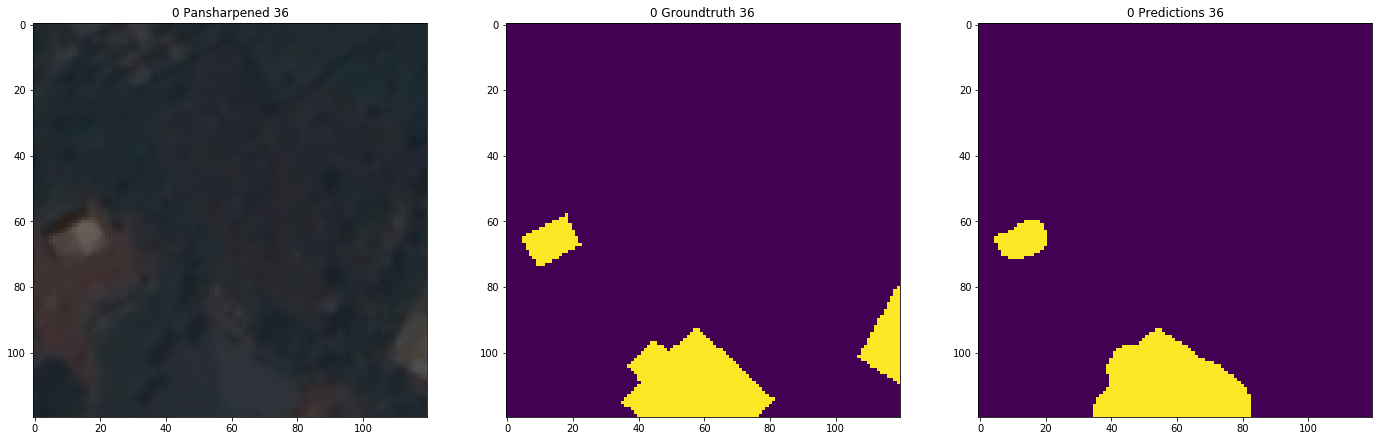

Is the grountruth true:Y or N?y
../2_CLEAN_DATA_GHANA/DATASET/120_x_120_8_pansh/TEST/INPUT/input_35.h5
Image 37, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00025674
Image 38, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00006071
Image 39, Validation IoU 0.2233, Validation IoU_acc 25.0000%,Validation F1 IoU 20.0000%, loss 0.64505947
Image 39, Validation IoU 0.2233, Validation IoU_acc 25.0000%,Validation F1 IoU 20.0000%, loss 0.64505947


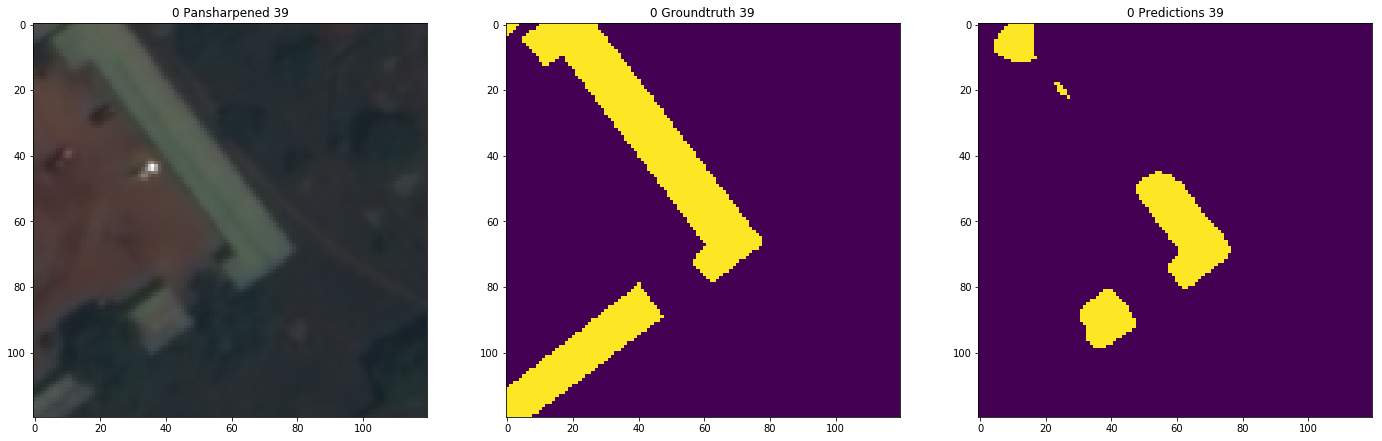

Is the grountruth true:Y or N?y
../2_CLEAN_DATA_GHANA/DATASET/120_x_120_8_pansh/TEST/INPUT/input_38.h5
Image 40, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00060531
Image 41, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00023555
Image 42, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00006545
Image 43, Validation IoU 0.9997, Validation IoU_acc 100.0000%,Validation F1 IoU 66.6667%, loss 0.00255165
Image 44, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00015945
Image 45, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00248557
Image 46, Validation IoU 0.9997, Validation IoU_acc 100.0000%,Validation F1 IoU 50.0000%, loss 0.00323761
Image 47, Validation IoU 0.9226, Validation IoU_acc 100.0000%,Validation F1 IoU 66.6667%, loss 0.27615449
Image 48, Validation IoU 1.0000, Validation 

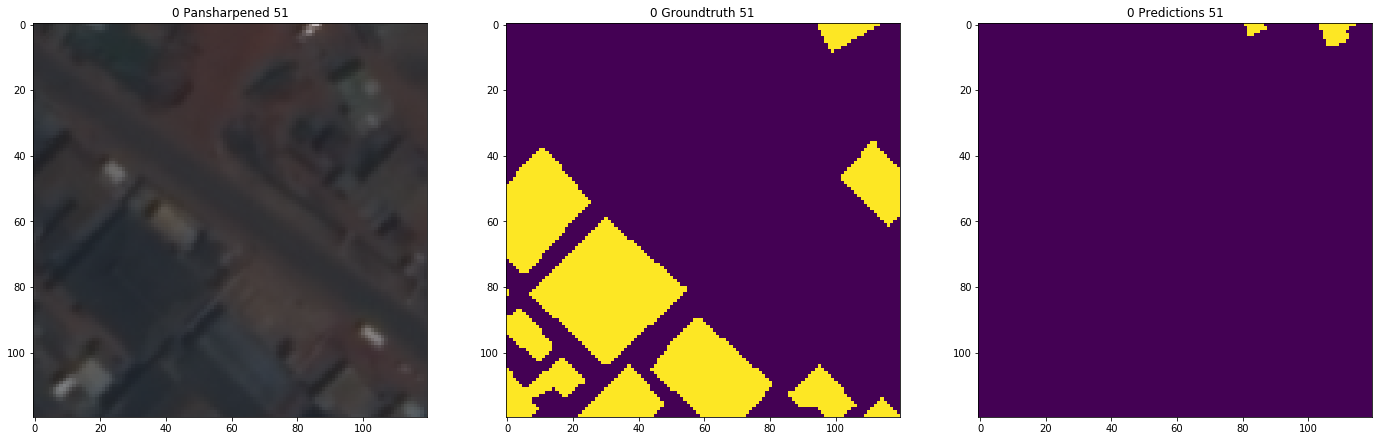

In [ ]:


    
    
model=UNet(INPUT_CHANNELS,NB_CLASSES,depth=DEFAULT_LAYERS,n_features_zero=DEFAULT_FEATURES_ROOT,dropout=0,width_kernel=DEFAULT_WIDTH_KERNEL)
model.cuda()
cudnn.benchmark = True
model.load_state_dict(torch.load(path_model))

generator=Dataset_sat.from_root_folder(path_data,NB_CLASSES)
loader=DataLoader(generator, batch_size=BATCH_SIZE,shuffle=True, num_workers=1)
counter_good=0
counter_wrong=0
for i_batch,sample_batch in enumerate(loader):
    X_val=standardize(sample_batch['input'])
    Y_val=sample_batch['groundtruth']

    predictions=[]
    for j in range(len(X_val)):
        X_val_j=X_val[j]
        X_val_j=X_val_j[newaxis,:,:,:]
        X_val_j=standardize(X_val_j)
        Y_val_j=Y_val[j]
        Y_val_j=Y_val_j[newaxis,:,:,:]

        X = Variable(X_val_j.float())
        X=X.permute(0,3,1,2).cuda()  
        Y = Variable(Y_val_j.float())
        Y=Y.cuda()  

        predictions_i=predict(model,X)
        loss_i=criterion(Y,predictions_i)
        loss_i=loss_i.data[0]
        predictions_i=predictions_i.data.cpu().numpy()
        Y_val_j=np.asarray(Y_val_j)
        iou_acc_v,f1_v,iou_v=predict_score_batch(TMP_IOU,np.argmax(Y_val_j,3),np.argmax(predictions_i,3))
        print("Image {:d}, Validation IoU {:.4f}, Validation IoU_acc {:.4f}%,Validation F1 IoU {:.4f}%, loss {:.8f}".format(j,iou_v,iou_acc_v,f1_v,loss_i))
        if iou_acc_v<100 and f1_v<100:
            print("Image {:d}, Validation IoU {:.4f}, Validation IoU_acc {:.4f}%,Validation F1 IoU {:.4f}%, loss {:.8f}".format(j,iou_v,iou_acc_v,f1_v,loss_i))

            fig,axs=plt.subplots(1, 3,figsize=(24,8))
            axs[0].set_title(str(i_batch)+' Pansharpened '+str(j), fontsize='large')
            axs[1].set_title(str(i_batch)+' Groundtruth '+str(j), fontsize='large')
            axs[2].set_title(str(i_batch)+' Predictions '+str(j), fontsize='large')
            pansharp=np.stack((X_val[j,:,:,5],X_val[j,:,:,3],X_val[j,:,:,2]),axis=2)
            axs[0].imshow(pansharp)
            axs[1].imshow(np.argmax(Y_val[j],2))
            axs[2].imshow(np.argmax(predictions_i[0],2))
            
            plt.show()
            answer=input('Is the grountruth true:Y or N?')
            if answer.lower()=='y':
                print(path_clean_data+'INPUT/input_'+str(counter_good)+'.h5')
                counter_good+=1
#                 write_data_h5(path_clean_data+'INPUT/input_'+str(counter_good)+'.h5',X_val[j])
#                 write_data_h5(path_clean_data+'OUTPUT/output_'+str(counter_good)+'.h5',np.argmax(Y_val[j],2))
            else:
                print(path_wrong_data+'INPUT/input_'+str(counter_wrong)+'.h5')
#                 write_data_h5(path_wrong_data+'INPUT/input_'+str(counter_wrong)+'.h5',X_val[j])
#                 write_data_h5(path_wrong_data+'OUTPUT/output_'+str(counter_wrong)+'.h5',np.argmax(Y_val[j],2))
                counter_wrong+=1
        else:
            
#             write_data_h5(path_clean_data+'INPUT/input_'+str(counter_good)+'.h5',X_val[j])
#             write_data_h5(path_clean_data+'OUTPUT/output_'+str(counter_good)+'.h5',np.argmax(Y_val[j],2))
            counter_good+=1

print('There are now %d elements in %s'%(counter_good,path_clean_data))
print('There are now %d elements in %s'%(counter_wrong,path_wrong_data))
